In [2]:
# Define the classifier
cls_model = models.resnet18(pretrained=True)
num_classes=4
num_ftrs = cls_model.fc.in_features
cls_model.fc = nn.Linear(num_ftrs, num_classes)
cls_model.to(device)

# Load the classifier
cls_model.load_state_dict(torch.load('./cls_resnet18.pt'))
cls_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# Classify test images

labels = ['fog', 'night', 'rain', 'sunny']
img_path = './dataset/test/test_img/'
annot_path = './dataset/test/test_annot/'

img_list = os.listdir(img_path)
img_list = natsort.natsorted(img_list)

fog_folder = './dataset/test/test_img_classified/fog'
night_folder = './dataset/test/test_img_classified/night'
rain_folder = './dataset/test/test_img_classified/rain'
sunny_folder = './dataset/test/test_img_classified/sunny'

fog_an_folder = './dataset/test/test_annot_classified/fog'
night_an_folder = './dataset/test/test_annot_classified/night'
rain_an_folder = './dataset/test/test_annot_classified/rain'
sunny_an_folder = './dataset/test/test_annot_classified/sunny'

for img in img_list:
    img_1 = Image.open(img_path+img).convert("RGB")
    img_2 = img_transforms(img_1).to(device)
    img_3 = torch.unsqueeze(img_2, 0)
    prediction = F.softmax(cls_model(img_3), dim=1)
    prediction = prediction.argmax()
    prediction_2 = labels[prediction]
    
    annot = img[:-3]+'xml'
    
    if prediction_2 == 'fog':
        shutil.copy(img_path+img,fog_folder)
        shutil.copy(annot_path+annot,fog_an_folder)     
    if prediction_2 == 'night':
        shutil.copy(img_path+img,night_folder)
        shutil.copy(annot_path+annot,night_an_folder)
    if prediction_2 == 'rain':
        shutil.copy(img_path+img,rain_folder)
        shutil.copy(annot_path+annot,rain_an_folder)
    if prediction_2 == 'sunny':
        shutil.copy(img_path+img,sunny_folder)
        shutil.copy(annot_path+annot,sunny_an_folder)

In [1]:
%run utils.ipynb

In [2]:
test_dataset_fog = RadarDataset_fog(data_transform, './dataset/test/test_img_classified/fog/')
test_data_loader_fog = torch.utils.data.DataLoader(test_dataset_fog, batch_size=1, collate_fn=collate_fn)

test_dataset_rain = RadarDataset_rain(data_transform, './dataset/test/test_img_classified/rain/')
test_data_loader_rain = torch.utils.data.DataLoader(test_dataset_rain, batch_size=1, collate_fn=collate_fn)

test_dataset_sunny = RadarDataset_sunny(data_transform, './dataset/test/test_img_classified/sunny/')
test_data_loader_sunny = torch.utils.data.DataLoader(test_dataset_sunny, batch_size=1, collate_fn=collate_fn)

test_dataset_night = RadarDataset_night(data_transform, './dataset/test/test_img_classified/night/')
test_data_loader_night = torch.utils.data.DataLoader(test_dataset_night, batch_size=1, collate_fn=collate_fn)

In [3]:
total_AP = []
sunny_AP = []
fog_AP = []
rain_AP = []
night_AP = []

model_fog = get_model_instance_segmentation(2)
model_fog.to(device)
model_rain = get_model_instance_segmentation(2)
model_rain.to(device)
model_sunny = get_model_instance_segmentation(2)
model_sunny.to(device)
model_night = get_model_instance_segmentation(2)
model_night.to(device)
    
for i in range(15):
    model_fog.load_state_dict(torch.load('./model/fog_+'+str(i+1)+'.pt'))
    model_rain.load_state_dict(torch.load('./model/rain_+'+str(i+1)+'.pt'))
    model_sunny.load_state_dict(torch.load('./model/sunny_+'+str(i+1)+'.pt'))
    model_night.load_state_dict(torch.load('./model/night_+'+str(i+1)+'.pt'))
    model_fog.eval()
    model_rain.eval()
    model_sunny.eval()
    model_night.eval()
        
    # Sunny AP Caculation
    
    model = model_sunny

    labels_sunny = []
    preds_adj_all_sunny = []
    annot_all_sunny = []

    for im, annot in tqdm(test_data_loader_sunny, position = 0, leave = True):
        im = list(img.to(device) for img in im)
        #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

        for t in annot:
            labels_sunny += t['labels']

        with torch.no_grad():
            preds_adj_sunny = make_prediction(model, im, 0.5)
            preds_adj_sunny = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_sunny]
            preds_adj_all_sunny.append(preds_adj_sunny)
            annot_all_sunny.append(annot)       
    preds_adj_all = preds_adj_all_sunny
    annot_all = annot_all_sunny
    labels = labels_sunny    
    sample_metrics = []
    for batch_i in range(len(preds_adj_all)):
        sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
    true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
    mAP_sunny = torch.mean(AP)
    sunny_AP.append(mAP_sunny.item())
    print(f'Sunny AP : {mAP_sunny}'+'_'+str(i+1))
    
    # Fog AP Caculation
    labels_fog = []
    preds_adj_all_fog = []
    annot_all_fog = []
    model = model_fog
    for im, annot in tqdm(test_data_loader_fog, position = 0, leave = True):
        im = list(img.to(device) for img in im)
        for t in annot:
            labels_fog += t['labels']
        with torch.no_grad():
            preds_adj_fog = make_prediction(model, im, 0.5)
            preds_adj_fog = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_fog]
            preds_adj_all_fog.append(preds_adj_fog)
            annot_all_fog.append(annot)            
    preds_adj_all = preds_adj_all_fog
    annot_all = annot_all_fog
    labels = labels_fog            
    sample_metrics = []
    for batch_i in range(len(preds_adj_all)):
        sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
    true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
    mAP_fog = torch.mean(AP)
    fog_AP.append(mAP_fog.item())
    print(f'Fog AP : {mAP_fog}'+'_'+str(i+1))
    
    # Rain AP Caculation
    model = model_rain
    labels_rain = []
    preds_adj_all_rain = []
    annot_all_rain = []

    for im, annot in tqdm(test_data_loader_rain, position = 0, leave = True):
        im = list(img.to(device) for img in im)
        #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

        for t in annot:
            labels_rain += t['labels']

        with torch.no_grad():
            preds_adj_rain = make_prediction(model, im, 0.5)
            preds_adj_rain = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_rain]
            preds_adj_all_rain.append(preds_adj_rain)
            annot_all_rain.append(annot)

    preds_adj_all = preds_adj_all_rain
    annot_all = annot_all_rain
    labels = labels_rain
    sample_metrics = []
    for batch_i in range(len(preds_adj_all)):
        sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
    true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
    mAP_rain = torch.mean(AP)
    rain_AP.append(mAP_rain.item())
    print(f'Rain AP : {mAP_rain}'+'_'+str(i+1))
    
    # Night AP Caculation
    model = model_night

    labels_night = []
    preds_adj_all_night = []
    annot_all_night = []

    for im, annot in tqdm(test_data_loader_night, position = 0, leave = True):
        im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

        for t in annot:
            labels_night += t['labels']

        with torch.no_grad():
            preds_adj_night = make_prediction(model, im, 0.5)
            preds_adj_night = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_night]
            preds_adj_all_night.append(preds_adj_night)
            annot_all_night.append(annot)

    preds_adj_all = preds_adj_all_night
    annot_all = annot_all_night
    labels = labels_night
    sample_metrics = []
    for batch_i in range(len(preds_adj_all)):
        sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
    true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
    mAP_night = torch.mean(AP)
    night_AP.append(mAP_night.item())
    print(f'Night AP : {mAP_night}'+'_'+str(i+1))
    
    # Sum up all data from different networks
    preds_adj_all = preds_adj_all_fog + preds_adj_all_rain + preds_adj_all_sunny+ preds_adj_all_night
    annot_all = annot_all_fog + annot_all_rain + annot_all_sunny + annot_all_night
    labels = labels_fog + labels_rain + labels_sunny + labels_night   
    
    # Total AP Caculation
    sample_metrics = []
    for batch_i in range(len(preds_adj_all)):
        sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
    true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
    mAP_total = torch.mean(AP)
    total_AP.append(mAP_total.item())
    print(f'Total AP : {mAP_total}'+'_'+str(i+1))

100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.69it/s]


Sunny AP : 0.9465870453747041_1


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.88it/s]


Fog AP : 0.8230267165014284_1


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.44it/s]


Rain AP : 0.8067249308499878_1


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.61it/s]


Night AP : 0.8861161860720532_1
Total AP : 0.8382978558899703_1


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.87it/s]


Sunny AP : 0.961680219567846_2


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.85it/s]


Fog AP : 0.8262536046236857_2


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.44it/s]


Rain AP : 0.857652620391379_2


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.72it/s]


Night AP : 0.9077789586141221_2
Total AP : 0.8762984157637432_2


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.76it/s]


Sunny AP : 0.9623382640575429_3


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.63it/s]


Fog AP : 0.9247028005034323_3


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.37it/s]


Rain AP : 0.8548081729124002_3


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.69it/s]


Night AP : 0.8934098557319103_3
Total AP : 0.8799766341684738_3


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.75it/s]


Sunny AP : 0.96174968740781_4


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.66it/s]


Fog AP : 0.9531153550382498_4


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.38it/s]


Rain AP : 0.9038540501661991_4


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.70it/s]


Night AP : 0.9391676648584508_4
Total AP : 0.9202133476814938_4


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.71it/s]


Sunny AP : 0.9646868045925174_5


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.67it/s]


Fog AP : 0.9391831288982786_5


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.37it/s]


Rain AP : 0.9201947362070069_5


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.64it/s]


Night AP : 0.9295474530042893_5
Total AP : 0.9285297314178209_5


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.71it/s]


Sunny AP : 0.9583564813515224_6


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.58it/s]


Fog AP : 0.9345729182672855_6


100%|█████████████████████████████████████████| 321/321 [00:26<00:00, 12.32it/s]


Rain AP : 0.9081313095998933_6


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.66it/s]


Night AP : 0.9227043707069136_6
Total AP : 0.9177048746685448_6


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.66it/s]


Sunny AP : 0.962529343393399_7


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.66it/s]


Fog AP : 0.9187680762941817_7


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.36it/s]


Rain AP : 0.9014207454554288_7


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.66it/s]


Night AP : 0.9152805538051956_7
Total AP : 0.9122780213526243_7


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.70it/s]


Sunny AP : 0.9629383246225238_8


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.64it/s]


Fog AP : 0.9110699451559405_8


100%|█████████████████████████████████████████| 321/321 [00:26<00:00, 12.29it/s]


Rain AP : 0.9135264106291157_8


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.81it/s]


Night AP : 0.9269908411360577_8
Total AP : 0.9212322117234355_8


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.82it/s]


Sunny AP : 0.9586977389435596_9


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.66it/s]


Fog AP : 0.933276535906792_9


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.44it/s]


Rain AP : 0.9089689548025408_9


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.76it/s]


Night AP : 0.9247354118993201_9
Total AP : 0.9191117141937166_9


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.67it/s]


Sunny AP : 0.9519658532175512_10


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.47it/s]


Fog AP : 0.9305113702873058_10


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.36it/s]


Rain AP : 0.9056977999163625_10


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.68it/s]


Night AP : 0.9172117649877762_10
Total AP : 0.9149909180112497_10


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.76it/s]


Sunny AP : 0.9559243780856903_11


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.77it/s]


Fog AP : 0.9346262880398619_11


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.44it/s]


Rain AP : 0.9007959233191123_11


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.64it/s]


Night AP : 0.922868742946422_11
Total AP : 0.9129676558848452_11


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.75it/s]


Sunny AP : 0.9556064909357929_12


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.58it/s]


Fog AP : 0.9263689077124688_12


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.43it/s]


Rain AP : 0.9062669169943316_12


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.65it/s]


Night AP : 0.9110827995913446_12
Total AP : 0.9141747634132473_12


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.78it/s]


Sunny AP : 0.9587402710840927_13


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.63it/s]


Fog AP : 0.9183714422860447_13


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.45it/s]


Rain AP : 0.9074580568970649_13


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.63it/s]


Night AP : 0.9169397568431537_13
Total AP : 0.9157202575477461_13


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.75it/s]


Sunny AP : 0.9488876932060375_14


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.69it/s]


Fog AP : 0.9308102407817564_14


100%|█████████████████████████████████████████| 321/321 [00:26<00:00, 12.32it/s]


Rain AP : 0.9030230319555361_14


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.66it/s]


Night AP : 0.913313091430334_14
Total AP : 0.911701525359371_14


100%|█████████████████████████████████████████| 300/300 [00:23<00:00, 12.74it/s]


Sunny AP : 0.9559250315524572_15


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 12.66it/s]


Fog AP : 0.9300721617568648_15


100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.41it/s]


Rain AP : 0.9055917760599232_15


100%|█████████████████████████████████████████| 296/296 [00:23<00:00, 12.68it/s]


Night AP : 0.9191478952838379_15
Total AP : 0.9153723155632019_15


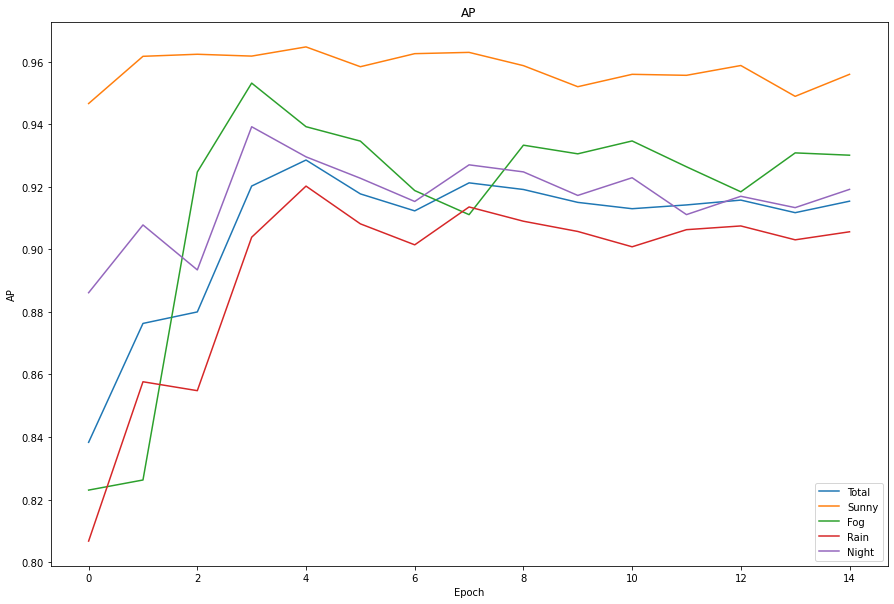

In [4]:
y1 = total_AP
y2 = sunny_AP
y3 = fog_AP
y4 = rain_AP
y5 = night_AP
x = list(range(0,len(y1)))

plt.figure(figsize=(15,10))
plt.plot(x, y1, label = "Total")
plt.plot(x, y2, label = "Sunny")
plt.plot(x, y3, label = "Fog")
plt.plot(x, y4, label = "Rain")
plt.plot(x, y5, label = "Night")
plt.xlabel('Epoch')
plt.ylabel('AP')
plt.title('AP')
plt.legend()
plt.show()

In [5]:
(m,i) = max((v,i) for i,v in enumerate(total_AP))
print (m,i)

(m,i) = max((v,i) for i,v in enumerate(sunny_AP))
print (m,i)

(m,i) = max((v,i) for i,v in enumerate(fog_AP))
print (m,i)

(m,i) = max((v,i) for i,v in enumerate(rain_AP))
print (m,i)

(m,i) = max((v,i) for i,v in enumerate(night_AP))
print (m,i)

0.9285297314178209 4
0.9646868045925174 4
0.9531153550382498 3
0.9201947362070069 4
0.9391676648584508 3


In [6]:
print(total_AP)
print(sunny_AP)
print(fog_AP)
print(rain_AP)
print(night_AP)

[0.8382978558899703, 0.8762984157637432, 0.8799766341684738, 0.9202133476814938, 0.9285297314178209, 0.9177048746685448, 0.9122780213526243, 0.9212322117234355, 0.9191117141937166, 0.9149909180112497, 0.9129676558848452, 0.9141747634132473, 0.9157202575477461, 0.911701525359371, 0.9153723155632019]
[0.9465870453747041, 0.961680219567846, 0.9623382640575429, 0.96174968740781, 0.9646868045925174, 0.9583564813515224, 0.962529343393399, 0.9629383246225238, 0.9586977389435596, 0.9519658532175512, 0.9559243780856903, 0.9556064909357929, 0.9587402710840927, 0.9488876932060375, 0.9559250315524572]
[0.8230267165014284, 0.8262536046236857, 0.9247028005034323, 0.9531153550382498, 0.9391831288982786, 0.9345729182672855, 0.9187680762941817, 0.9110699451559405, 0.933276535906792, 0.9305113702873058, 0.9346262880398619, 0.9263689077124688, 0.9183714422860447, 0.9308102407817564, 0.9300721617568648]
[0.8067249308499878, 0.857652620391379, 0.8548081729124002, 0.9038540501661991, 0.9201947362070069, 0.9

In [7]:
# Load models
model_fog.load_state_dict(torch.load('./model/fog_+4.pt'))
model_rain.load_state_dict(torch.load('./model/rain_+5.pt'))
model_sunny.load_state_dict(torch.load('./model/sunny_+5.pt'))
model_night.load_state_dict(torch.load('./model/night_+4.pt'))

<All keys matched successfully>

In [8]:
# fog
from tqdm import tqdm

model = model_fog

labels_fog = []
preds_adj_all_fog = []
annot_all_fog = []

for im, annot in tqdm(test_data_loader_fog, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels_fog += t['labels']

    with torch.no_grad():
        preds_adj_fog = make_prediction(model, im, 0.5)
        preds_adj_fog = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_fog]
        preds_adj_all_fog.append(preds_adj_fog)
        annot_all_fog.append(annot)

preds_adj_all = preds_adj_all_fog
annot_all = annot_all_fog
labels = labels_fog

sample_metrics = []

for batch_i in range(len(preds_adj_all)): # len(preds_adj_all) : The number of batches
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 13.42it/s]

mAP : 0.9531153550382498
AP : tensor([0.9531], dtype=torch.float64)


In [9]:
# rain
from tqdm import tqdm

model = model_rain

labels_rain = []
preds_adj_all_rain = []
annot_all_rain = []

for im, annot in tqdm(test_data_loader_rain, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels_rain += t['labels']

    with torch.no_grad():
        preds_adj_rain = make_prediction(model, im, 0.5)
        preds_adj_rain = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_rain]
        preds_adj_all_rain.append(preds_adj_rain)
        annot_all_rain.append(annot)

preds_adj_all = preds_adj_all_rain
annot_all = annot_all_rain
labels = labels_rain

sample_metrics = []

for batch_i in range(len(preds_adj_all)): # len(preds_adj_all) : The number of batches
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

100%|█████████████████████████████████████████| 321/321 [00:25<00:00, 12.77it/s]


mAP : 0.9201947362070069
AP : tensor([0.9202], dtype=torch.float64)


In [10]:
# sunny
from tqdm import tqdm

model = model_sunny

labels_sunny = []
preds_adj_all_sunny = []
annot_all_sunny = []

for im, annot in tqdm(test_data_loader_sunny, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels_sunny += t['labels']

    with torch.no_grad():
        preds_adj_sunny = make_prediction(model, im, 0.5)
        preds_adj_sunny = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_sunny]
        preds_adj_all_sunny.append(preds_adj_sunny)
        annot_all_sunny.append(annot)
        
preds_adj_all = preds_adj_all_sunny
annot_all = annot_all_sunny
labels = labels_sunny

sample_metrics = []

for batch_i in range(len(preds_adj_all)): # len(preds_adj_all) : The number of batches
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.06it/s]


mAP : 0.9646868045925174
AP : tensor([0.9647], dtype=torch.float64)


In [11]:
# night
from tqdm import tqdm

model = model_night

labels_night = []
preds_adj_all_night = []
annot_all_night = []

for im, annot in tqdm(test_data_loader_night, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels_night += t['labels']

    with torch.no_grad():
        preds_adj_night = make_prediction(model, im, 0.5)
        preds_adj_night = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_night]
        preds_adj_all_night.append(preds_adj_night)
        annot_all_night.append(annot)

preds_adj_all = preds_adj_all_night
annot_all = annot_all_night
labels = labels_night

sample_metrics = []

for batch_i in range(len(preds_adj_all)): # len(preds_adj_all) : The number of batches
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

100%|█████████████████████████████████████████| 296/296 [00:22<00:00, 12.98it/s]


mAP : 0.9391676648584508
AP : tensor([0.9392], dtype=torch.float64)


In [12]:
# Sum up all data from different networks
preds_adj_all = preds_adj_all_fog + preds_adj_all_rain + preds_adj_all_sunny+ preds_adj_all_night
annot_all = annot_all_fog + annot_all_rain + annot_all_sunny + annot_all_night
labels = labels_fog + labels_rain + labels_sunny + labels_night

# Overall AP

sample_metrics = []

for batch_i in range(len(preds_adj_all)): # len(preds_adj_all) : The number of batches
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.9311827162474948
AP : tensor([0.9312], dtype=torch.float64)
